<a href="https://colab.research.google.com/github/reddy-bhavesh/ATFL-Detect/blob/main/torch_ATFL_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
import cv2
import numpy as np
import os
from google.colab import drive
from sklearn.metrics import confusion_matrix, classification_report, jaccard_score
import seaborn as sns

# Mount the drive
drive.mount('/content/drive')

# Dataset paths
train_path = '/content/drive/My Drive/dataset1/train'
valid_path = '/content/drive/My Drive/dataset1/validation'
test_path = '/content/drive/My Drive/dataset1/test'

# Dataset class
class ATFLDataset(Dataset):
    def __init__(self, images, labels):
        self.X = images
        self.y = labels
        self.transform = transforms.Compose([transforms.ToPILImage(), transforms.ToTensor()])

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        data = self.transform(self.X[idx])
        label = torch.tensor(self.y[idx], dtype=torch.long)
        return data, label

# Load dataset
def load_dataset(path):
    images = []
    labels = []
    for label_dir in os.listdir(path):
        label = 0 if label_dir == 'normal' else 1
        img_dir = os.path.join(path, label_dir)
        for img_name in os.listdir(img_dir):
            img_path = os.path.join(img_dir, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
            img = cv2.resize(img, (512, 512))
            images.append(img)
            labels.append(label)
    return np.array(images), np.array(labels)

X_train, y_train = load_dataset(train_path)
X_valid, y_valid = load_dataset(valid_path)
X_test, y_test = load_dataset(test_path)

train_set = ATFLDataset(X_train, y_train)
valid_set = ATFLDataset(X_valid, y_valid)
test_set = ATFLDataset(X_test, y_test)

train_gen = DataLoader(train_set, batch_size=2, shuffle=True)
valid_gen = DataLoader(valid_set, batch_size=2, shuffle=True)
test_gen = DataLoader(test_set, batch_size=2, shuffle=True)

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model
resnet_model = models.resnet50(pretrained=True)
for param in resnet_model.parameters():
    param.requires_grad = True

n_inputs = resnet_model.fc.in_features
resnet_model.fc = nn.Sequential(nn.Linear(n_inputs, 512),
                                nn.ReLU(),
                                nn.Dropout(0.4),
                                nn.Linear(512, 2),
                                nn.LogSoftmax(dim=1))

resnet_model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet_model.parameters(), lr=0.001, momentum=0.9)

# Training
epochs = 30
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

for epoch in range(epochs):
    resnet_model.train()
    train_loss = 0
    correct = 0
    total = 0
    for X, y in train_gen:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        output = resnet_model(X)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(output, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()
    train_losses.append(train_loss / len(train_gen))
    train_accuracies.append(100 * correct / total)

    resnet_model.eval()
    valid_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for X, y in valid_gen:
            X, y = X.to(device), y.to(device)
            output = resnet_model(X)
            loss = criterion(output, y)
            valid_loss += loss.item()
            _, predicted = torch.max(output, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()
    valid_losses.append(valid_loss / len(valid_gen))
    valid_accuracies.append(100 * correct / total)

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Valid Loss: {valid_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}, Valid Acc: {valid_accuracies[-1]:.2f}')

# Save model
torch.save(resnet_model.state_dict(), '/content/drive/My Drive/ATFL_resnet50_model_1.pt')


Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 104MB/s]


Epoch 1/30, Train Loss: 0.7961, Valid Loss: 0.7054, Train Acc: 50.00, Valid Acc: 50.00
Epoch 2/30, Train Loss: 0.7209, Valid Loss: 0.6992, Train Acc: 50.00, Valid Acc: 50.00
Epoch 3/30, Train Loss: 0.7141, Valid Loss: 0.7007, Train Acc: 50.00, Valid Acc: 25.00
Epoch 4/30, Train Loss: 0.6864, Valid Loss: 0.6948, Train Acc: 50.00, Valid Acc: 50.00
Epoch 5/30, Train Loss: 0.6807, Valid Loss: 0.6920, Train Acc: 75.00, Valid Acc: 50.00
Epoch 6/30, Train Loss: 0.6260, Valid Loss: 0.6907, Train Acc: 75.00, Valid Acc: 50.00
Epoch 7/30, Train Loss: 0.6803, Valid Loss: 0.6918, Train Acc: 50.00, Valid Acc: 75.00
Epoch 8/30, Train Loss: 0.6788, Valid Loss: 0.6953, Train Acc: 25.00, Valid Acc: 50.00
Epoch 9/30, Train Loss: 0.6566, Valid Loss: 0.6994, Train Acc: 75.00, Valid Acc: 50.00
Epoch 10/30, Train Loss: 0.5878, Valid Loss: 0.7013, Train Acc: 100.00, Valid Acc: 50.00
Epoch 11/30, Train Loss: 0.5671, Valid Loss: 0.6945, Train Acc: 75.00, Valid Acc: 50.00
Epoch 12/30, Train Loss: 0.5136, Valid L

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Test Accuracy: 100.00%


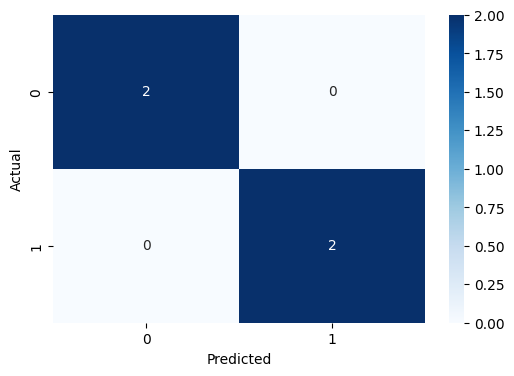

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4

Jaccard Index:
 1.0


In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
import cv2
import numpy as np
import os
from google.colab import drive
from sklearn.metrics import confusion_matrix, classification_report, jaccard_score
import seaborn as sns

# Mount the drive
drive.mount('/content/drive')

# Dataset paths
test_path = '/content/drive/My Drive/dataset1/test'

# Dataset class
class ATFLDataset(Dataset):
    def __init__(self, images, labels):
        self.X = images
        self.y = labels
        self.transform = transforms.Compose([transforms.ToPILImage(), transforms.ToTensor()])

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        data = self.transform(self.X[idx])
        label = torch.tensor(self.y[idx], dtype=torch.long)
        return data, label

# Load dataset
def load_dataset(path):
    images = []
    labels = []
    for label_dir in os.listdir(path):
        label = 0 if label_dir == 'normal' else 1
        img_dir = os.path.join(path, label_dir)
        for img_name in os.listdir(img_dir):
            img_path = os.path.join(img_dir, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
            img = cv2.resize(img, (512, 512))
            images.append(img)
            labels.append(label)
    return np.array(images), np.array(labels)

X_test, y_test = load_dataset(test_path)

test_set = ATFLDataset(X_test, y_test)
test_gen = DataLoader(test_set, batch_size=2, shuffle=True)

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model
resnet_model = models.resnet50(pretrained=True)
for param in resnet_model.parameters():
    param.requires_grad = True

n_inputs = resnet_model.fc.in_features
resnet_model.fc = nn.Sequential(nn.Linear(n_inputs, 512),
                                nn.ReLU(),
                                nn.Dropout(0.4),
                                nn.Linear(512, 2),
                                nn.LogSoftmax(dim=1))

resnet_model.to(device)

# Load the saved model weights
resnet_model.load_state_dict(torch.load('/content/drive/My Drive/ATFL_resnet50_model_1.pt'))

# Hook to extract features
features = []

def hook(module, input, output):
    features.append(output)

# Register hook
layer = resnet_model.layer4[1].conv2  # You can choose any layer you want
hook_handle = layer.register_forward_hook(hook)

# Test
resnet_model.eval()
correct = 0
total = 0
all_labels = []
all_preds = []

with torch.no_grad():
    for X, y in test_gen:
        X, y = X.to(device), y.to(device)
        output = resnet_model(X)
        _, predicted = torch.max(output, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()
        all_labels.extend(y.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

print(f'Test Accuracy: {100 * correct / total:.2f}%')

# Visualize features
def visualize_feature_maps(features):
    num_features = features.shape[1]
    fig, axes = plt.subplots(1, num_features, figsize=(30, 30))
    for i, ax in enumerate(axes):
        ax.imshow(features[0, i].cpu().numpy(), cmap='viridis')
        ax.axis('off')
    plt.show()

# Get a batch of test data
X, _ = next(iter(test_gen))
X = X.to(device)

# Forward pass to get the features
resnet_model(X)

# Visualize the features from the hooked layer
feature_maps = features[0].detach()
visualize_feature_maps(feature_maps)

# Confusion Matrix and Classification Report
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("Classification Report:\n", classification_report(all_labels, all_preds))
print("Jaccard Index:\n", jaccard_score(all_labels, all_preds, average='macro'))
